In [10]:
from scipy.optimize import linprog
import numpy as np
import math
from electricity_prices import read_prices
from datetime import datetime, timedelta

import json
import pandas as pd

# Hackaton

C -> Electricity Cost

72 weights ( represent the cost of each hour per mode)
- w00, w01, w02, w03, w04, w05, w06, w07, ...

modes (hours_mode_off, hours_mode_eco, hours_mode_confort)
- h_00_off, h_00_eco, h_00_conf, h_01_off, h_01_eco, h_01_conf, ...

this modes are binary variables (0 or 1)


Expression
- C = w00*h_00_off + w01*h_00_eco + w02*h_00_conf + w03*h_01_off + w04*h_01_eco + w05*h_01_conf + w06*h_02_off + w07*h_02_eco + w08*h_02_conf + ...


Contraints

Binary Variables and Confort score at least 124
- h_00_off + h_00_eco + h_00_conf = 1
- h_01_off + h_01_eco + h_01_conf = 1
...
 - 124 <= (h_00_eco + h_01_eco + h_02_eco + ... + h_23_eco)*4 +(h_00_conf + h_01_conf + ... + h_23_conf)*8

In [68]:
def OptimizeCost(Weights, consumptionForEachWeight, minumum_confort_score=124):
    """inputs:
    Weights: list of weights for each hour
    contraints: list of contraints
    bounds: list of bounds
    integrality: 1 : Integer variable; decision variable must be an integer within bounds."""



    lhs_eq = [[1, 1, 1]+[0]*69, [0]*3+[1]*3+[0]*66, [0]*6+[1]*3+[0]*63, [0]*9+[1]*3+[0]*60, [0]*12+[1]*3+[0]*57, [0]*15+[1]*3+[0]*54, [0]*18+[1]*3+[0]*51, [0]*21+[1]*3+[0]*48, [0]*24+[1]*3+[0]*45, [0]*27+[1]*3+[0]*42, [0]*30+[1]*3+[0]*39, [0]*33+[1]*3+[0]*36, [0]*36+[1]*3+[0]*33, [0]*39+[1]*3+[0]*30, [0]*42+[1]*3+[0]*27, [0]*45+[1]*3+[0]*24, [0]*48+[1]*3+[0]*21, [0]*51+[1]*3+[0]*18, [0]*54+[1]*3+[0]*15, [0]*57+[1]*3+[0]*12, [0]*60+[1]*3+[0]*9, [0]*63+[1]*3+[0]*6, [0]*66+[1]*3+[0]*3, [0]*69+[1]*3]
    rhs_eq = [1]*24

    lhs_ineq = [[0, -4, -8, 0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8,0, -4, -8]]
    rhs_ineq = [-minumum_confort_score]

    bounds = [(0,1) for i in range(72)]
    integrality = [1 for i in range(72)]

    opt = linprog(c=Weights, A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bounds, integrality=integrality,
              method="highs")

    #find if its eco, off or conf and conver to string 
    policy = np.array(opt['x']).reshape(24,3).argmax(axis=1)
    #convert array number to off, eco or confort
    policy = np.vectorize(lambda x: 'off' if x == 0 else 'eco' if x == 1 else 'conf')(policy)
    
    cost = opt['fun']
    score = np.array(minumum_confort_score)+opt['ineqlin']['residual'][0]
    
    #comfort score accumulated across the day
    accumulated_comfort_score = [8 if policy[i] == 'conf' else 4 if policy[i] == 'eco' else 0 for i in range(24)]
    for i in range(1,24):
        accumulated_comfort_score[i] = accumulated_comfort_score[i-1]+accumulated_comfort_score[i]
    
    #cost accumulated across the day
    #need to check weights and see which are active

    #Consumo energético atual e acumulado -> weights
    accumulated_cost = []
    accumulated_comsumption = []
    weights_count = 0
    for mode in policy:
        if mode == 'conf':
            accumulated_cost.append(Weights[2+weights_count])
            accumulated_comsumption.append(consumptionForEachWeight[2+weights_count])
        elif mode == 'eco':
            accumulated_cost.append(Weights[1+weights_count])
            accumulated_comsumption.append(consumptionForEachWeight[1+weights_count])
        else:
            accumulated_cost.append(Weights[weights_count])
            accumulated_comsumption.append(consumptionForEachWeight[weights_count])
        weights_count += 3
    atual_cost= accumulated_cost.copy()
    atual_comsumption= accumulated_comsumption.copy()
    for i in range(1,24):
        accumulated_cost[i] = accumulated_cost[i-1]+accumulated_cost[i]
        accumulated_comsumption[i] = accumulated_comsumption[i-1]+accumulated_comsumption[i]

    #Comsumption accumulated across the day
    # receives the consumption for each weight
       

    return policy, cost, score, accumulated_comfort_score, atual_cost, accumulated_cost, atual_comsumption, accumulated_comsumption


In [69]:
def calculateWeights(temperature_array, energy_cost_array):
    #Temperature array is the temperature for each hour of the day
    #Energy cost array is the cost of energy for each hour of the day

    #calculate the weights for each hour
    weights = []
    comsumption = []
    modes = ['off', 'eco', 'conf']
    for i in range(len(temperature_array)):
        for mode in modes:
            external_temp = temperature_array[i]
            if mode == 'off':
                #1KW/hour regardless of temperature
                weights.append(energy_cost_array[i]*1)
                comsumption.append(1)
            elif mode == 'eco':
                if external_temp < 10:
                    #1.6KW/hour
                    weights.append(energy_cost_array[i]*1.6)
                    comsumption.append(1.6)
                elif external_temp >= 10 and external_temp <= 20:
                    #0.8KW/hour
                    weights.append(energy_cost_array[i]*0.8)
                    comsumption.append(0.8)
                elif external_temp > 20:
                    #0.4KW/hour
                    weights.append(energy_cost_array[i]*0.4)
                    comsumption.append(0.4)
            elif mode == 'conf':

                if external_temp < 0:
                    #2.4KW/hour+9KW/hour
                    weights.append(energy_cost_array[i]*(2.4+9))
                    comsumption.append(2.4+9)
                elif external_temp < 10:
                    #2.4KW/hour
                    weights.append(energy_cost_array[i]*2.4)
                    comsumption.append(2.4)
                elif external_temp >= 10 and external_temp <= 20:
                    #1.6KW/hour
                    weights.append(energy_cost_array[i]*1.6)
                    comsumption.append(1.6)
                elif external_temp > 20:
                    #0.8KW/hour
                    weights.append(energy_cost_array[i]*0.8)
                    comsumption.append(0.8)
    return weights, comsumption
    
        


In [70]:
#read json file with temperatures
with open('data/temp_data.json') as json_file:
    data = json.load(json_file)


In [71]:
def get_temperature_array(date_string):
    #date_string is a string in the format '2021-12-01'
    #returns an array of temperatures for the day
    with open('data/temp_data.json') as json_file:
        data = json.load(json_file)
    df = pd.DataFrame(data)
    df['dt'] = pd.to_datetime(df['dt'], unit='s')
    target_day = pd.to_datetime(date_string).date()
    df_day = df[df['dt'].dt.date == target_day]
    temperature_array = df_day['temp'].to_numpy()
    return temperature_array

def get_energy_array(date_string):
    #date_string is a string in the format '2021-12-01'
    #returns an array of energy prices for the day
    t0 = pd.to_datetime(date_string) - pd.Timedelta(days=1)
    energy_array = read_prices(t0, t0)[0]
    return energy_array


In [72]:
date = '2021-12-01'
temperature_array = get_temperature_array(date)
energy_array = get_energy_array(date)
results = OptimizeCost(calculateWeights(temperature_array, energy_array), minumum_confort_score=124)
print("Policy: ", results[0])
print("Electricity Cost (euros): ", results[1])
print("Confort Score: ", results[2])

[0.61284, 0.6, 0.582624, 0.541608, 0.528288, 0.577104, 0.4355359999999999, 0.46860799999999997, 0.479008, 0.47819200000000006, 0.471008, 0.4534560000000001, 0.43200000000000005, 0.43200000000000005, 0.433632, 0.4355359999999999, 0.45126400000000005, 0.48, 0.49488000000000004, 0.4841600000000001, 0.48096000000000005, 0.47968000000000005, 0.450144, 0.6119279999999999]
[0.61284, 1.21284, 1.795464, 2.337072, 2.86536, 3.4424639999999997, 3.8779999999999997, 4.346608, 4.825616, 5.303808, 5.774816, 6.2282720000000005, 6.660272000000001, 7.092272000000001, 7.5259040000000015, 7.961440000000001, 8.412704000000002, 8.892704000000002, 9.387584000000002, 9.871744000000001, 10.352704000000001, 10.832384000000001, 11.282528000000001, 11.894456000000002]
Policy:  ['conf' 'conf' 'conf' 'conf' 'conf' 'conf' 'eco' 'eco' 'eco' 'eco' 'eco'
 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco' 'eco'
 'conf']
Electricity Cost (euros):  11.894456
Confort Score:  124.0


/Users/rmelo/Documents/Hackaton/electricity_prices.py:23: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.



([<matplotlib.axis.YTick at 0x7faccd937430>,
 [Text(0, 0, 'conf'), Text(0, 1, 'eco'), Text(0, 2, 'off')])

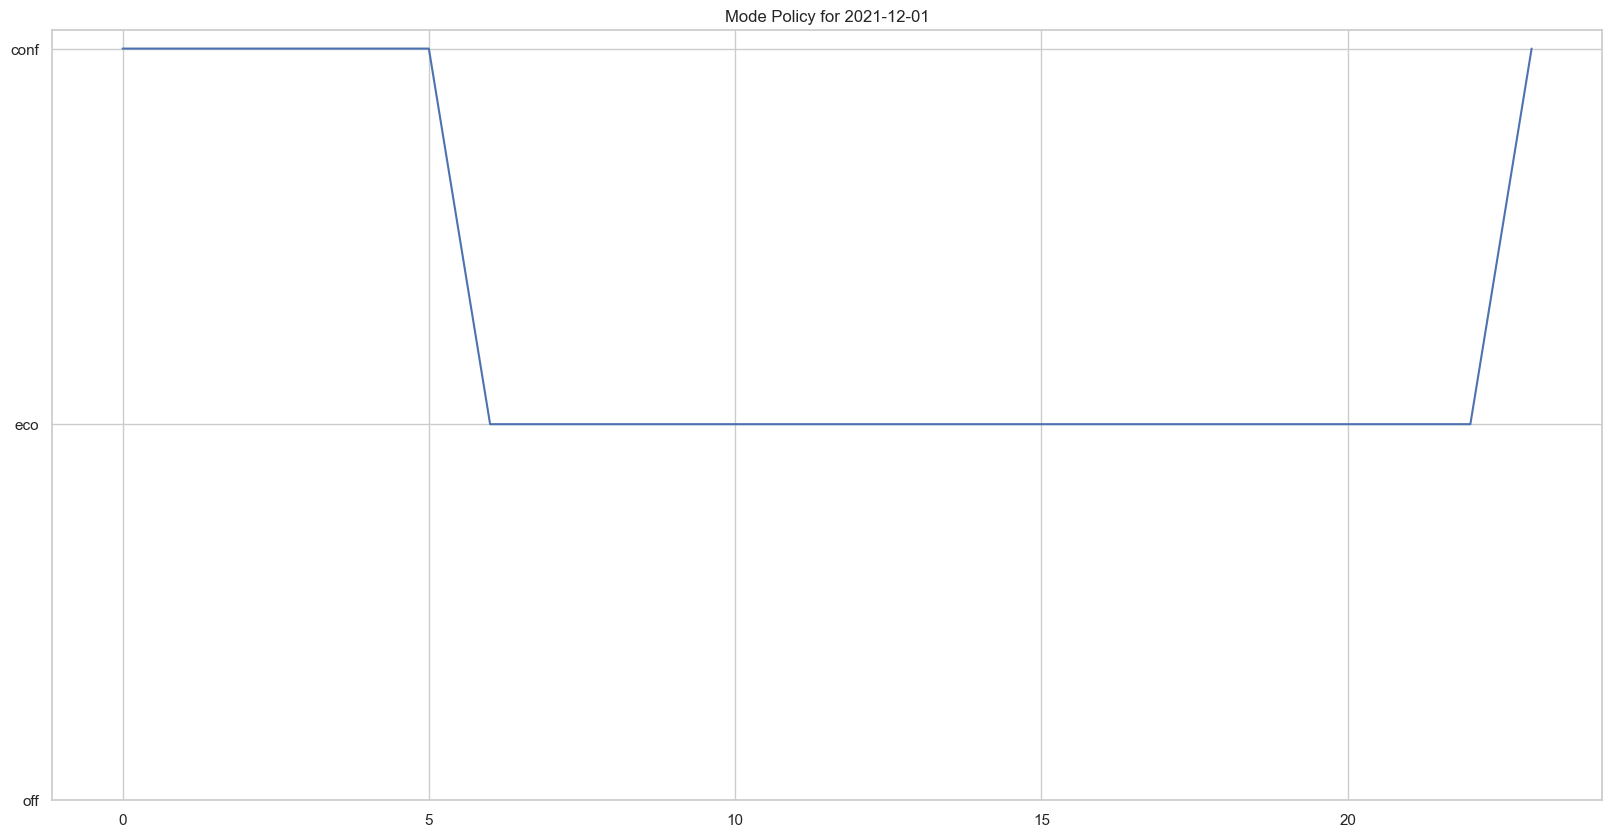

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
#plot the different modes across the day and the energy cost during the day 
plt.figure(figsize=(20,10))

plt.title("Mode Policy for 2021-12-01")
#plot results[0] with y axis order being like ['off', 'eco', 'conf']


plt.plot(results[0])

#change order of y axis to ['off', 'eco', 'conf']
plt.gca().invert_yaxis()
plt.yticks([0,1,2], ['conf', 'eco', 'off'])


#plt.plot(np.vectorize(lambda x: 0 if x == 'off' else 1 if x == 'eco' else 2)(results[0]))

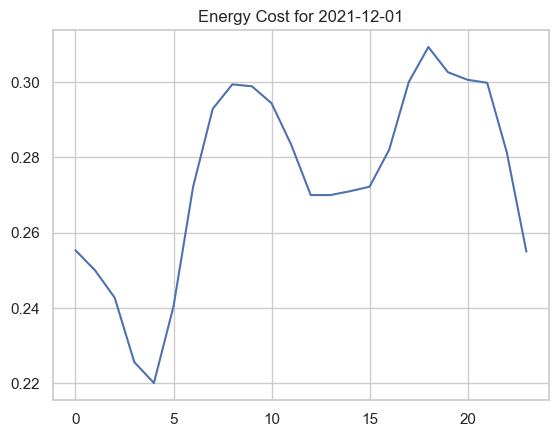

In [45]:
plt.title('Energy Cost for 2021-12-01')
plt.plot(energy_array)
